In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import inspect 

import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
sys.path.append(project_root)

from models.baseline_model import BaselineModel
from models.collaborative_memory_model import CollaborativeMemoryModel
from models.collaborative_model_based import CollaborativeModelBased
from models.content_based_model import ContentBasedModel
from models.session_based_model import SessionBasedModel

/home/jupyter/.local/lib/python3.10/site-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [2]:
def load_all_models():
    """
    📂 Load all trained models from their respective directories and return them as a dictionary.
    """
    models = {}

    try:
        print("\n📂 Loading Baseline Model...")
        models['Baseline'] = BaselineModel.load_model("../models/baseline_model/")
        print("✅ Baseline model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading Baseline Model: {e}")
        models['Baseline'] = None

    try:
        print("\n📂 Loading Content-Based Model...")
        models['ContentBased'] = ContentBasedModel.load_model("../models/content_based_model.pkl")
        print("✅ Content-Based model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading Content-Based Model: {e}")
        models['ContentBased'] = None

    try:
        print("\n📂 Loading Collaborative Memory-Based Model...")
        models['CollaborativeMemory'] = CollaborativeMemoryModel.load_model("../models/collaborative_memory_model.pkl")
        print("✅ Collaborative Memory-Based model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading Collaborative Memory-Based Model: {e}")
        models['CollaborativeMemory'] = None

    try:
        print("\n📂 Loading Collaborative Model-Based Model...")
        models['CollaborativeModelBased'] = CollaborativeModelBased.load_model("../models/collaborative_model_based/")
        print("✅ Collaborative Model-Based model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading Collaborative Model-Based Model: {e}")
        models['CollaborativeModelBased'] = None

    try:
        print("\n📂 Loading Session-Based Model...")
        models['SessionBased'] = SessionBasedModel.load_model("../models/session_based_model")
        print("✅ Session-Based model loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading Session-Based Model: {e}")
        models['SessionBased'] = None

    return models

In [3]:
def evaluate_model(model, test_df, train_df, model_name, k=10):
    """
    📈 Evaluate a single model on the test set.
    """
    print(f"\n📈 Evaluating {model_name}...")
    if model is None:
        print(f"⚠️ Skipping {model_name} evaluation due to model load failure.")
        return None
    
    hit_rates, precisions, recalls, ndcgs, aps, rrs = [], [], [], [], [], []

    # Check if the recommend method requires 'train_df'
    recommend_signature = inspect.signature(model.recommend)
    requires_train_df = 'train_df' in recommend_signature.parameters

    for user_id in test_df["userId"].unique():
        relevant_items = test_df.filter(pl.col("userId") == user_id)["jokeId"].to_list()
        try:
            # 🔥 Call the recommend method of the model, pass train_df if required
            if requires_train_df:
                recommended_jokes = model.recommend(user_id, train_df=train_df, top_n=k)
            else:
                recommended_jokes = model.recommend(user_id, top_n=k)
        except Exception as e:
            print(f"⚠️ Error recommending for user {user_id} in {model_name}: {e}")
            recommended_jokes = []

        hit_rates.append(user_hitrate(relevant_items, recommended_jokes, k))
        precisions.append(user_precision(relevant_items, recommended_jokes, k))
        recalls.append(user_recall(relevant_items, recommended_jokes, k))
        ndcgs.append(user_ndcg(relevant_items, recommended_jokes, k))
        aps.append(user_ap(relevant_items, recommended_jokes, k))
        rrs.append(user_rr(relevant_items, recommended_jokes, k))
    
    # Calculate and print the final metrics
    final_metrics = {
        'HitRate': np.mean(hit_rates) if hit_rates else 0,
        'Precision': np.mean(precisions) if precisions else 0,
        'Recall': np.mean(recalls) if recalls else 0,
        'NDCG': np.mean(ndcgs) if ndcgs else 0,
        'AP': np.mean(aps) if aps else 0,
        'RR': np.mean(rrs) if rrs else 0,
    }

    print(f"\n📊 Results for {model_name}:")
    for metric_name, metric_value in final_metrics.items():
        print(f"   📌 {metric_name}@{k}: {metric_value:.4f}")

    return final_metrics

In [4]:
def evaluate_all_models(test_df, train_df, k=10):
    """
    📊 Load and evaluate all models on the test dataset.
    """
    print("\n📂 Loading trained models...")
    models = load_all_models()

    results = {}
    for model_name, model in models.items():
        if model is not None:
            results[model_name] = evaluate_model(model, test_df, train_df, model_name, k)
        else:
            print(f"⚠️ Skipping {model_name} as the model was not loaded successfully.")
    
    return results

In [5]:
# 📈 Helper functions to calculate metrics
def user_intersection(y_rel, y_rec, k=10):
    return len(set(y_rec[:k]).intersection(set(y_rel)))


def user_hitrate(y_rel, y_rec, k=10):
    return int(user_intersection(y_rel, y_rec, k) > 0)


def user_precision(y_rel, y_rec, k=10):
    return user_intersection(y_rel, y_rec, k) / k


def user_recall(y_rel, y_rec, k=10):
    return user_intersection(y_rel, y_rec, k) / len(set(y_rel)) if len(set(y_rel)) > 0 else 0


def user_ap(y_rel, y_rec, k=10):
    return np.sum([
        user_precision(y_rel, y_rec, idx + 1)
        for idx, item in enumerate(y_rec[:k]) if item in y_rel
    ]) / k


def user_rr(y_rel, y_rec, k=10):
    for idx, item in enumerate(y_rec[:k]):
        if item in y_rel:
            return 1 / (idx + 1)
    return 0


def user_ndcg(y_rel, y_rec, k=10):
    dcg = sum([1. / np.log2(idx + 2) for idx, item in enumerate(y_rec[:k]) if item in y_rel])
    idcg = sum([1. / np.log2(idx + 2) for idx, _ in enumerate(zip(y_rel, np.arange(k)))])
    return dcg / idcg if idcg > 0 else 0

In [6]:
train_df = pl.read_parquet("../data/processed/train_features.parquet")
test_df = pl.read_parquet("../data/processed/test_features.parquet")
results = evaluate_all_models(test_df, train_df, k=10)


📂 Loading trained models...

📂 Loading Baseline Model...
📂 Loading Baseline Model from ../models/baseline_model/...
✅ Model loaded successfully from ../models/baseline_model/.
✅ Baseline model loaded successfully.

📂 Loading Content-Based Model...
📦 Model loaded successfully from ../models/content_based_model.pkl
✅ Content-Based model loaded successfully.

📂 Loading Collaborative Memory-Based Model...
📦 Loading entire CollaborativeMemoryModel from ../models/collaborative_memory_model.pkl...
✅ Collaborative Memory-Based model loaded successfully from ../models/collaborative_memory_model.pkl
✅ Collaborative Memory-Based model loaded successfully.

📂 Loading Collaborative Model-Based Model...
📦 Loading Collaborative Filtering model from ../models/collaborative_model_based/...
📐 Loaded User-Item Matrix shape: (13095, 133)
✅ Model loaded from ../models/collaborative_model_based/ with 13095 users and 133 items.
✅ Collaborative Model-Based model loaded successfully.

📂 Loading Session-Based 

/home/jupyter/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()



📊 Results for Baseline:
   📌 HitRate@10: 0.2548
   📌 Precision@10: 0.0327
   📌 Recall@10: 0.0523
   📌 NDCG@10: 0.0454
   📌 AP@10: 0.0111
   📌 RR@10: 0.0860

📈 Evaluating ContentBased...

📊 Results for ContentBased:
   📌 HitRate@10: 0.3004
   📌 Precision@10: 0.0390
   📌 Recall@10: 0.0704
   📌 NDCG@10: 0.0650
   📌 AP@10: 0.0150
   📌 RR@10: 0.1172

📈 Evaluating CollaborativeMemory...

📊 Results for CollaborativeMemory:
   📌 HitRate@10: 0.2211
   📌 Precision@10: 0.0258
   📌 Recall@10: 0.0566
   📌 NDCG@10: 0.0362
   📌 AP@10: 0.0069
   📌 RR@10: 0.0566

📈 Evaluating CollaborativeModelBased...

📊 Results for CollaborativeModelBased:
   📌 HitRate@10: 0.1701
   📌 Precision@10: 0.0204
   📌 Recall@10: 0.0311
   📌 NDCG@10: 0.0265
   📌 AP@10: 0.0064
   📌 RR@10: 0.0521

📈 Evaluating SessionBased...

📊 Results for SessionBased:
   📌 HitRate@10: 0.0000
   📌 Precision@10: 0.0000
   📌 Recall@10: 0.0000
   📌 NDCG@10: 0.0000
   📌 AP@10: 0.0000
   📌 RR@10: 0.0000


In [7]:
# 📋 Extract model names and metric values
model_names = list(results.keys())
hitrate_values = [results[model]['HitRate'] for model in model_names]
precision_values = [results[model]['Precision'] for model in model_names]
recall_values = [results[model]['Recall'] for model in model_names]
ndcg_values = [results[model]['NDCG'] for model in model_names]
ap_values = [results[model]['AP'] for model in model_names]
rr_values = [results[model]['RR'] for model in model_names]

In [8]:
# 🎨 Define color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

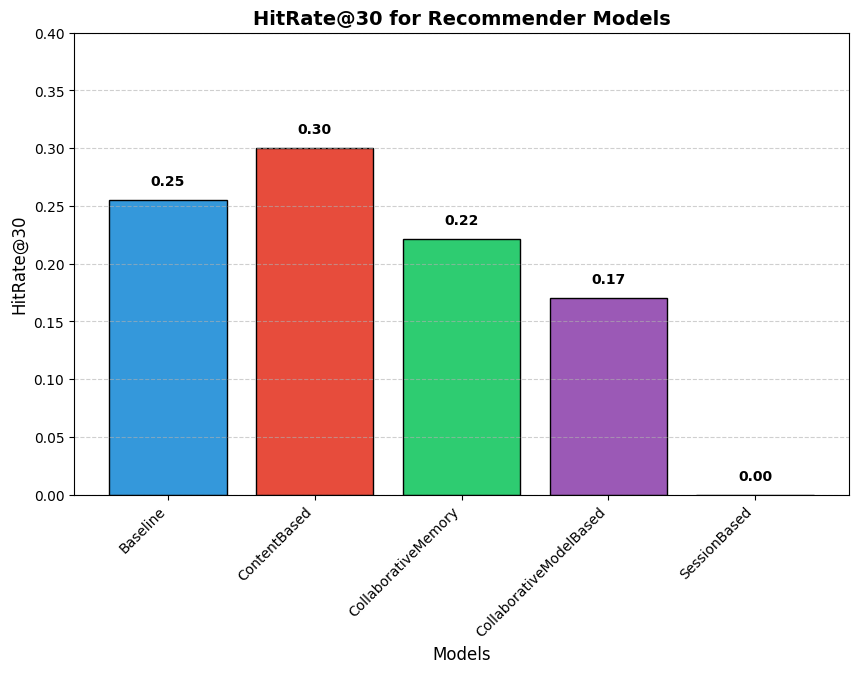

In [9]:
# 📈 Create a bar plot for HitRate@30
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, hitrate_values, color=colors, edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('HitRate@30 for Recommender Models', fontsize=14, fontweight='bold')
plt.ylabel('HitRate@30', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 0.4)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

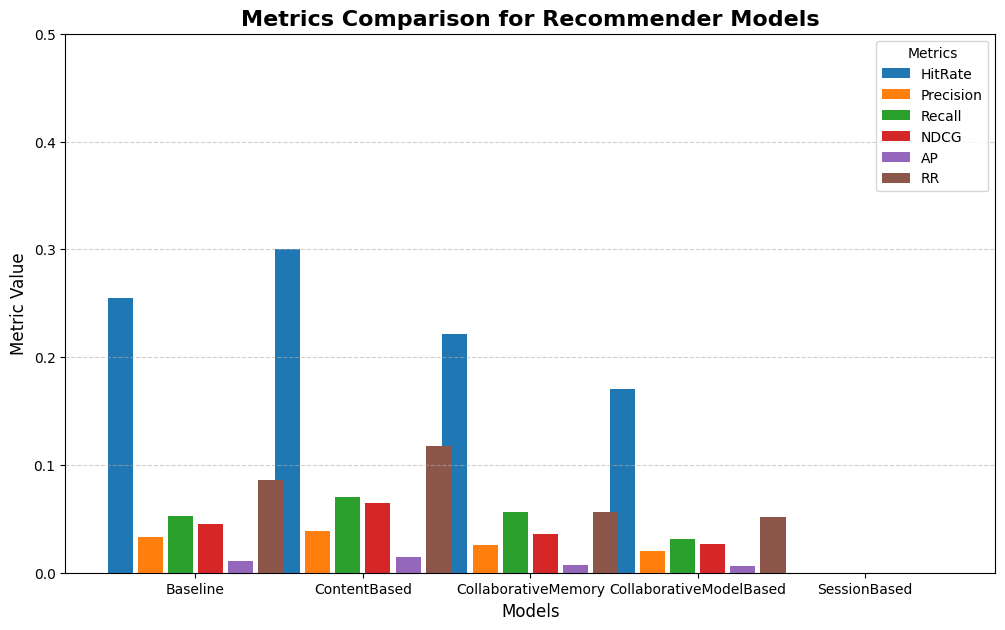

In [10]:
# 📊 Multi-metric comparison for all models
metrics = ['HitRate', 'Precision', 'Recall', 'NDCG', 'AP', 'RR']
values = {
    'HitRate': hitrate_values,
    'Precision': precision_values,
    'Recall': recall_values,
    'NDCG': ndcg_values,
    'AP': ap_values,
    'RR': rr_values
}

x = np.arange(len(model_names)) 
width = 0.15 
num_metrics = len(metrics)
offsets = np.linspace(-width * (num_metrics // 2), width * (num_metrics // 2), num_metrics)

plt.figure(figsize=(12, 7))

for i, metric in enumerate(metrics):
    plt.bar(x + offsets[i], values[metric], width, label=metric)

plt.xticks(x, model_names)
plt.title('Metrics Comparison for Recommender Models', fontsize=16, fontweight='bold')
plt.ylabel('Metric Value', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.legend(title='Metrics')
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()